In [139]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
 
import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn import preprocessing 
# from sklearn.model_selection import StratifiedKFold
# import time
# import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

seed=47

In [104]:
# load data
client_train=pd.read_csv('data/client_train.csv')  
client_test=pd.read_csv('data/client_test.csv')
invoice_train=pd.read_csv('data/invoice_train.csv')
invoice_test=pd.read_csv('data/invoice_test.csv')
# sample_submission = pd.read_csv('data/SampleSubmission.csv')

In [89]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_test.shape)

(135493, 6) (4476749, 16) (58069, 5) (1939730, 16)


In [90]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [91]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [63]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [64]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [92]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 16
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [93]:
#Getting unique values on the client train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [94]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [105]:
# 0.7 0.3 split
client_test_percent = client_test.shape[0]/(client_train.shape[0]+client_test.shape[0])*100 #30% testing
invoice_test_percent = invoice_test.shape[0]/(invoice_train.shape[0]+invoice_test.shape[0])*100 #30% testing

print(f"Percent of client test to train {client_test_percent} %")
print(f"Percent of invoice test to train {invoice_test_percent} %")

Percent of client test to train 30.000206652132132 %
Percent of invoice test to train 30.230442583853232 %


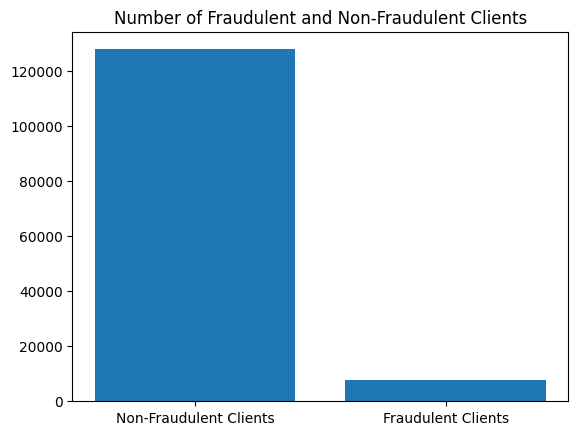

In [106]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label =['Non-Fraudulent Clients', 'Fraudulent Clients'])
plt.title('Number of Fraudulent and Non-Fraudulent Clients')
plt.show()
#Target is highly imbalanced with fewer cases of fraudulent activities

Our dataset is highly imbalanced. This means the number of non-fraudulent customers (0) 
is significantly greater than the number of fraudulent ones (1). 
This situation is completely normal for fraud detection tasks, but we must pay close attention to it 
when building our model to ensure it doesn't simply predict everything as "non-fraudulent.

In [107]:
#Column cleanup p1
client_train.rename(columns={'disrict': 'district'}, inplace=True)
print(client_train.columns)
client_test.rename(columns={'disrict': 'district'}, inplace=True)
print(client_test.columns)

Index(['district', 'client_id', 'client_catg', 'region', 'creation_date',
       'target'],
      dtype='object')
Index(['district', 'client_id', 'client_catg', 'region', 'creation_date'], dtype='object')


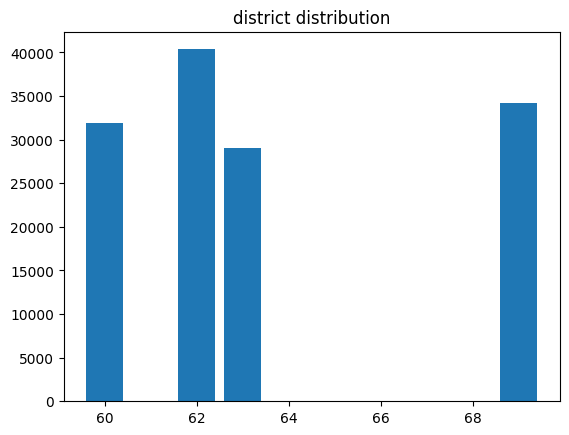

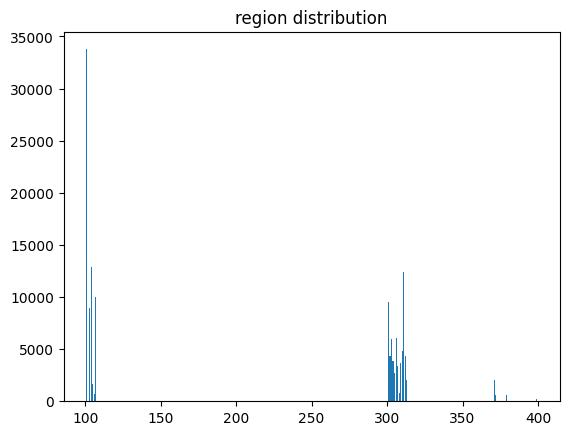

In [108]:
#Visualize client distribution across districts and regions
for col in ['district','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

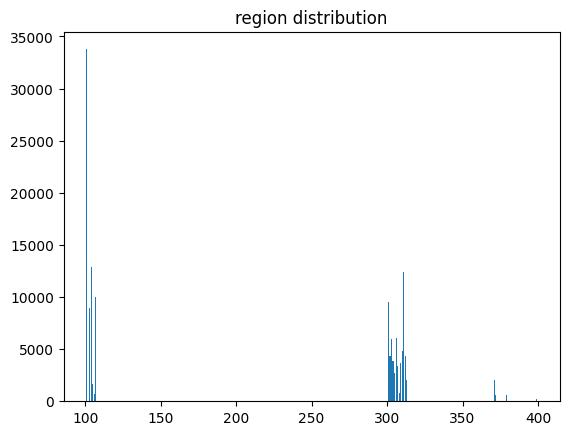

In [109]:
ds = client_train.groupby(['region'])['client_id'].count()
plt.bar(x=ds.index, height=ds.values)
plt.title('region distribution')
plt.show()

# Feature Engineering

In [110]:
# Check the data types of the columns
print(client_train.info())

# Alternatively, specifically find the columns with text (object) data type
object_cols = client_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", list(object_cols))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   district       135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB
None
Non-numeric columns: ['client_id', 'creation_date']


In [111]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [112]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [113]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['district'] = client_train['district'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['district'] = client_test['district'].astype(int)

In [114]:

# It's good practice to work on a copy of your dataframe
df_processed = client_train.copy()

# 1. Handle the 'creation_date' column
# Convert the column to a proper datetime format
df_processed['creation_date'] = pd.to_datetime(df_processed['creation_date'])

# Extract numerical features from the date
df_processed['creation_year'] = df_processed['creation_date'].dt.year
df_processed['creation_month'] = df_processed['creation_date'].dt.month
df_processed['creation_dayofweek'] = df_processed['creation_date'].dt.dayofweek

# 2. Define your features (X) and target (y)
# We drop the original date column and the client_id
X = df_processed.drop(columns=['target', 'creation_date', 'client_id'])
y = df_processed['target']

# --- Verification Step ---
# Check the info for X to confirm all columns are now numeric
print("Data types of the final features (X):")
X.info()

Data types of the final features (X):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   district            135493 non-null  int64
 1   client_catg         135493 non-null  int64
 2   region              135493 non-null  int64
 3   creation_year       135493 non-null  int32
 4   creation_month      135493 non-null  int32
 5   creation_dayofweek  135493 non-null  int32
dtypes: int32(3), int64(3)
memory usage: 4.7 MB


In [115]:
# --- Feature Engineering & Preprocessing ---

# Handle the 'creation_date' column by extracting numerical features
client_train['creation_date'] = pd.to_datetime(client_train['creation_date'])
client_train['creation_year'] = client_train['creation_date'].dt.year
client_train['creation_month'] = client_train['creation_date'].dt.month
client_train['creation_dayofweek'] = client_train['creation_date'].dt.dayofweek

# Process the invoice data
# Convert invoice_date to datetime
invoice_train['invoice_date'] = pd.to_datetime(invoice_train['invoice_date'])

# Encode 'counter_type' using mapping
d = {"ELEC": 0, "GAZ": 1}
invoice_train['counter_type'] = invoice_train['counter_type'].map(d)

# Aggregate invoice data by client
def aggregate_by_client_id(invoice_data):
    aggs = {
        'consommation_level_1': ['mean'],
        'consommation_level_2': ['mean'],
        'consommation_level_3': ['mean'],
        'consommation_level_4': ['mean'],
        'months_number': ['mean', 'max'] # Added more aggregations for richness
    }
    agg_trans = invoice_data.groupby('client_id').agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='transactions_count'))
    
    return pd.merge(df, agg_trans, on='client_id', how='left')

agg_train = aggregate_by_client_id(invoice_train)

In [116]:
# --- 1. Prepare Data ---
# Merge aggregated invoice data with client data
train_df = pd.merge(client_train, agg_train, on='client_id', how='left')

# Drop unnecessary columns
# 'creation_date' is now represented by numerical features
# 'client_id' is an identifier and not a feature
X = train_df.drop(columns=['target', 'creation_date', 'client_id'])
y = train_df['target']

# Assuming X is the feature data and y are the labels (0 and 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [117]:
# Build the baseline model Logistic Regression

# class_weight='balanced' automatically gives a higher weight to the minority class (1)
baseline_model = LogisticRegression(class_weight='balanced', solver='liblinear')

# Train the model
baseline_model.fit(X_train, y_train)

# Make predictions
y_pred = baseline_model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

# Calculate AUC-PR
y_probs = baseline_model.predict_proba(X_test)[:, 1] # Probability of belonging to class 1
 
precision, recall, _ = precision_recall_curve(y_test, y_probs)
print(f"AUC-PR Score: {auc(recall, precision)}")


              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79     38378
         1.0       0.10      0.59      0.17      2270

    accuracy                           0.67     40648
   macro avg       0.53      0.63      0.48     40648
weighted avg       0.92      0.67      0.76     40648

AUC-PR Score: 0.09790590115103792


In [118]:
# --- 2. Train Model ---
print("--- Training Logistic Regression Baseline Model ---")
baseline_lr_model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
baseline_lr_model.fit(X_train, y_train)

# --- 3. Make Predictions ---
y_probs_lr = baseline_lr_model.predict_proba(X_test)[:, 1]
y_pred_lr_hard = baseline_lr_model.predict(X_test) # Uses default 0.5 threshold

# --- 4. Evaluate ---
print("\n--- Logistic Regression Baseline Evaluation ---")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_hard))

# Confusion Matrix for Logistic Regression (at default 0.5 threshold)

print("\nConfusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_lr_hard))

# Calculate AUC-PR
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_probs_lr)
auc_pr_lr = auc(recall_lr, precision_lr)
print(f"AUC-PR Score (Logistic Regression): {auc_pr_lr}")

# Optional: Add ROC AUC Score
roc_auc_lr = roc_auc_score(y_test, y_probs_lr)
print(f"ROC AUC Score (Logistic Regression): {roc_auc_lr}")

--- Training Logistic Regression Baseline Model ---

--- Logistic Regression Baseline Evaluation ---

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79     38378
         1.0       0.10      0.59      0.17      2270

    accuracy                           0.67     40648
   macro avg       0.53      0.63      0.48     40648
weighted avg       0.92      0.67      0.76     40648


Confusion Matrix (Logistic Regression):
[[25693 12685]
 [  921  1349]]
AUC-PR Score (Logistic Regression): 0.09790590115103792
ROC AUC Score (Logistic Regression): 0.6909492360137497


# Our baseline model Interpretation:
Good Recall (0.60 for fraud): The model is effective at catching a majority of the actual fraudsters, identifying 60% of all fraudulent cases. This is a strong starting point.

Very Poor Precision (0.10 for fraud): This is the main weakness. When the model predicts an account is fraudulent, it is only correct 10% of the time. This leads to a high number of false positives, meaning many legitimate customers would be incorrectly flagged.

Low AUC-PR Score (0.098): This score confirms that while the model is better than random, its overall ability to balance finding fraud (recall) and being accurate (precision) is low.

In short: The model is good at finding fraud but is overly sensitive, resulting in too many false alarms. The next step is to improve its precision without significantly hurting its ability to recall fraudulent cases.

In [119]:
print(baseline_model.coef_)
print(baseline_model.intercept_)

[[ 3.36289803e-03  2.23286456e-03  4.38254257e-04 -6.58842945e-04
  -1.80061381e-04  4.54476623e-06  2.23180166e-02  2.52618369e-05
   5.79924780e-06  3.17927239e-03 -5.19127783e-05 -8.41172256e-05
   3.34182237e-05]]
[3.03723337e-06]


## Random Forest

In [125]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=42, criterion="entropy", class_weight='balanced') # Added class_weight='balanced' 
random_forest.fit(X_train,y_train)

# Get predicted probabilities for the positive class (class 1)
random_forest_predictions_proba = random_forest.predict_proba(X_test)[:,1]
random_forest_predictions_hard = random_forest.predict(X_test)


# --- Evaluation for Random Forest ---

print("--- Random Forest Model Evaluation ---")

# 1. Classification Report (Precision, Recall, F1-score)
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, random_forest_predictions_hard))

# 2. Calculate AUC-PR Score
# precision_recall_curve requires probabilities
rf_precision, rf_recall, _ = precision_recall_curve(y_test, random_forest_predictions_proba)
rf_auc_pr_score = auc(rf_recall, rf_precision)
print(f"Random Forest AUC-PR Score: {rf_auc_pr_score}")

# 3. (Optional but good to keep) ROC AUC Score
rf_roc_auc_score = roc_auc_score(y_test, random_forest_predictions_proba)
print(f"Random Forest ROC AUC Score: {rf_roc_auc_score}")

--- Random Forest Model Evaluation ---

Classification Report (Random Forest):
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     38378
         1.0       0.32      0.00      0.01      2270

    accuracy                           0.94     40648
   macro avg       0.63      0.50      0.49     40648
weighted avg       0.91      0.94      0.92     40648

Random Forest AUC-PR Score: 0.15918214239471087
Random Forest ROC AUC Score: 0.7474499145182985


*Current situation:* Even though the ROC AUC Score looks good, the recall plummeted down (fraud detection class 1.0) to 0. 

_Complication:_ This means model is to conservative - not detecting the fraud.

_Solution:_  In steps, default threshold 0.5 has to be adjusted, class_weight changed, SMOTE (Synthetic Minority Oversampling Technique)

In [128]:
# --- Step 1
# --- Experiment with different thresholds ---
class_weight_threshold = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5] # Add more granular thresholds if needed

print("\n--- Random Forest Evaluation at Different Thresholds ---")
for t in class_weight_threshold:
    # Apply the threshold to get hard predictions
    y_pred_at_threshold = (random_forest_predictions_proba >= t).astype(int)

    precision = precision_score(y_test, y_pred_at_threshold, pos_label=1)
    recall = recall_score(y_test, y_pred_at_threshold, pos_label=1)
    f1 = f1_score(y_test, y_pred_at_threshold, pos_label=1)

    print(f"\nThreshold: {t:.2f}")
    print(f"  Precision (Fraud): {precision:.2f}")
    print(f"  Recall (Fraud):    {recall:.2f}")
    print(f"  F1-score (Fraud):  {f1:.2f}")
    # Optional: Print confusion matrix for detailed view
    print("  Confusion Matrix:\n", confusion_matrix(y_test, y_pred_at_threshold))


--- Random Forest Evaluation at Different Thresholds ---

Threshold: 0.05
  Precision (Fraud): 0.10
  Recall (Fraud):    0.74
  F1-score (Fraud):  0.18
  Confusion Matrix:
 [[23437 14941]
 [  585  1685]]

Threshold: 0.10
  Precision (Fraud): 0.15
  Recall (Fraud):    0.49
  F1-score (Fraud):  0.22
  Confusion Matrix:
 [[31811  6567]
 [ 1156  1114]]

Threshold: 0.15
  Precision (Fraud): 0.19
  Recall (Fraud):    0.31
  F1-score (Fraud):  0.23
  Confusion Matrix:
 [[35343  3035]
 [ 1572   698]]

Threshold: 0.20
  Precision (Fraud): 0.23
  Recall (Fraud):    0.18
  F1-score (Fraud):  0.20
  Confusion Matrix:
 [[36978  1400]
 [ 1856   414]]

Threshold: 0.25
  Precision (Fraud): 0.26
  Recall (Fraud):    0.10
  F1-score (Fraud):  0.15
  Confusion Matrix:
 [[37689   689]
 [ 2032   238]]

Threshold: 0.30
  Precision (Fraud): 0.30
  Recall (Fraud):    0.06
  F1-score (Fraud):  0.10
  Confusion Matrix:
 [[38062   316]
 [ 2132   138]]

Threshold: 0.40
  Precision (Fraud): 0.30
  Recall (Fraud):

Based on the F1-score, the best performing threshold is 0.15, which gives us an F1-score of 0.23.

Threshold 0.15:
Precision (Fraud): 0.19 (Meaning 19% of what the model flags as fraud is actually fraud). 
Recall (Fraud): 0.30 (Meaning the model catches 30% of actual fraudsters). 

In [129]:
# --- ADOPT THE OPTIMAL THRESHOLD ---
# This is the optimal threshold determined from your previous tuning steps
optimal_threshold = 0.15

# Apply the chosen threshold to get hard predictions
y_pred_at_optimal_threshold = (random_forest_predictions_proba >= optimal_threshold).astype(int)

# --- Final Evaluation with the Chosen Optimal Threshold ---
print(f"--- Random Forest Model Evaluation with Optimal Threshold {optimal_threshold:.2f} ---")

# Calculate individual metrics for the optimal threshold
precision_fraud = precision_score(y_test, y_pred_at_optimal_threshold, pos_label=1, zero_division=0)
recall_fraud = recall_score(y_test, y_pred_at_optimal_threshold, pos_label=1, zero_division=0)
f1_fraud = f1_score(y_test, y_pred_at_optimal_threshold, pos_label=1, zero_division=0)


print("\n---------------------------------------------------------")
print(f"Optimal Threshold (based on F1-score): {optimal_threshold:.3f}")
print(f"Best F1-score (Fraud):                 {f1_fraud:.2f}")
print(f"Precision at optimal threshold:        {precision_fraud:.2f}")
print(f"Recall at optimal threshold:           {recall_fraud:.2f}")
print("---------------------------------------------------------")

# Final Classification Report
print(f"\nFinal Classification Report with Optimal Threshold ({optimal_threshold:.3f}):")
print(classification_report(y_test, y_pred_at_optimal_threshold))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_at_optimal_threshold))

# Calculate AUC-PR (based on probabilities, so it's independent of the chosen threshold)
rf_precision_curve, rf_recall_curve, _ = precision_recall_curve(y_test, random_forest_predictions_proba)
rf_auc_pr_score = auc(rf_recall_curve, rf_precision_curve)
print(f"\nRandom Forest AUC-PR Score (based on probabilities): {rf_auc_pr_score:.4f}") # Formatted for consistency

# Calculate ROC AUC Score (based on probabilities, independent of threshold)
rf_roc_auc_score = roc_auc_score(y_test, random_forest_predictions_proba)
print(f"Random Forest ROC AUC Score (based on probabilities): {rf_roc_auc_score:.4f}") # Formatted for consistency

--- Random Forest Model Evaluation with Optimal Threshold 0.15 ---

---------------------------------------------------------
Optimal Threshold (based on F1-score): 0.150
Best F1-score (Fraud):                 0.23
Precision at optimal threshold:        0.19
Recall at optimal threshold:           0.31
---------------------------------------------------------

Final Classification Report with Optimal Threshold (0.150):
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     38378
         1.0       0.19      0.31      0.23      2270

    accuracy                           0.89     40648
   macro avg       0.57      0.61      0.59     40648
weighted avg       0.91      0.89      0.90     40648


Confusion Matrix:
[[35343  3035]
 [ 1572   698]]

Random Forest AUC-PR Score (based on probabilities): 0.1592
Random Forest ROC AUC Score (based on probabilities): 0.7474


In [130]:
# Step 2 
# --- Calculate Custom Class_Weight and Train Model ---
print("--- Calculating Custom Class_Weight ---")
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_factor = neg_count / pos_count
print(f"Base scale factor (neg_count / pos_count): {scale_factor:.2f}")

# Experiment with multiplying this factor
# Current example: giving class 1 (fraud) 5x more weight than 'balanced'
custom_class_weights = {0: 1, 1: scale_factor * 5}
print(f"Custom Class Weights used: {custom_class_weights}")

print("\n--- Training Random Forest Model with Custom Weights ---")
random_forest_custom_weights = RandomForestClassifier(
    random_state=42,
    criterion="entropy",
    class_weight=custom_class_weights # Use your custom weights here
)
random_forest_custom_weights.fit(X_train, y_train)

# --- Make Predictions ---
# Get predicted probabilities for the positive class (class 1, fraud)
random_forest_predictions_proba_custom_weights = random_forest_custom_weights.predict_proba(X_test)[:, 1]

# --- Find Optimal Threshold and Best Metrics ---
# We still need the loop to DETERMINE the best threshold, but we won't print each step.
class_weight_threshold = [0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]

best_f1_custom_weights = 0
optimal_threshold_custom_weights = 0
optimal_precision_custom_weights = 0
optimal_recall_custom_weights = 0

for t in class_weight_threshold:
    y_pred_at_threshold = (random_forest_predictions_proba_custom_weights >= t).astype(int)

    precision = precision_score(y_test, y_pred_at_threshold, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred_at_threshold, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred_at_threshold, pos_label=1, zero_division=0)

    if f1 > best_f1_custom_weights:
        best_f1_custom_weights = f1
        optimal_threshold_custom_weights = t
        optimal_precision_custom_weights = precision
        optimal_recall_custom_weights = recall

# --- Print Best Result ---
print("\n--- Random Forest (Custom Weights) Best Performance ---")
print("---------------------------------------------------------")
print(f"Optimal Threshold (based on F1-score): {optimal_threshold_custom_weights:.3f}")
print(f"Best F1-score (Fraud):                 {best_f1_custom_weights:.2f}")
print(f"Precision at optimal threshold:        {optimal_precision_custom_weights:.2f}")
print(f"Recall at optimal threshold:           {optimal_recall_custom_weights:.2f}")
print("---------------------------------------------------------")

# --- Final Evaluation with the Optimal Threshold ---
y_pred_final_custom_weights = (random_forest_predictions_proba_custom_weights >= optimal_threshold_custom_weights).astype(int)

# Classification Report
print(f"\nFinal Classification Report with Optimal Threshold ({optimal_threshold_custom_weights:.3f}):")
print(classification_report(y_test, y_pred_final_custom_weights))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_final_custom_weights))

# Calculate AUC-PR
pr_curve_custom_weights, rec_curve_custom_weights, _ = precision_recall_curve(y_test, random_forest_predictions_proba_custom_weights)
auc_pr_custom_weights = auc(rec_curve_custom_weights, pr_curve_custom_weights)
print(f"\nAUC-PR Score: {auc_pr_custom_weights:.4f}")

# Calculate ROC AUC Score
roc_auc_custom_weights = roc_auc_score(y_test, random_forest_predictions_proba_custom_weights)
print(f"ROC AUC Score: {roc_auc_custom_weights:.4f}")

--- Calculating Custom Class_Weight ---
Base scale factor (neg_count / pos_count): 16.91
Custom Class Weights used: {0: 1, 1: 84.54399546827794}

--- Training Random Forest Model with Custom Weights ---

--- Random Forest (Custom Weights) Best Performance ---
---------------------------------------------------------
Optimal Threshold (based on F1-score): 0.150
Best F1-score (Fraud):                 0.23
Precision at optimal threshold:        0.19
Recall at optimal threshold:           0.29
---------------------------------------------------------

Final Classification Report with Optimal Threshold (0.150):
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     38378
         1.0       0.19      0.29      0.23      2270

    accuracy                           0.89     40648
   macro avg       0.57      0.61      0.59     40648
weighted avg       0.91      0.89      0.90     40648


Confusion Matrix:
[[35604  2774]
 [ 1613   657]]

AUC-PR S

In [131]:
# --- Define and Train Random Forest Model with Ideal Class_Weight ---
print("--- Training Random Forest Model with Ideal Class Weights ---")

# Your ideal class_weight as determined from previous tuning
ideal_class_weights = {0: 1, 1: 84.54399546827794}
print(f"Applying ideal Class Weights: {ideal_class_weights}")

random_forest_ideal_weights = RandomForestClassifier(
    class_weight=ideal_class_weights,
    criterion='entropy',
    random_state=42
)
random_forest_ideal_weights.fit(X_train, y_train)

# --- Make Predictions (probabilities) ---
y_probs_ideal_weights = random_forest_ideal_weights.predict_proba(X_test)[:, 1]

# --- Final Evaluation at Optimal Threshold for THIS Ideal Class_Weight ---
# Based on previous tuning with class_weight={0: 1, 1: 84.54...},
# the optimal F1-score was found at Threshold: 0.100.
optimal_threshold_for_ideal_weights = 0.100

# Apply the optimal threshold to get hard predictions (0 or 1)
y_pred_ideal_weights = (y_probs_ideal_weights >= optimal_threshold_for_ideal_weights).astype(int)

# --- Print Core Metrics for the Best Result ---
print(f"\n--- Random Forest (Ideal Class Weights) Performance at Optimal Threshold {optimal_threshold_for_ideal_weights:.3f} ---")

# Calculate individual metrics for the optimal threshold
precision_fraud = precision_score(y_test, y_pred_ideal_weights, pos_label=1, zero_division=0)
recall_fraud = recall_score(y_test, y_pred_ideal_weights, pos_label=1, zero_division=0)
f1_fraud = f1_score(y_test, y_pred_ideal_weights, pos_label=1, zero_division=0)

print("\n---------------------------------------------------------")
print(f"Optimal Threshold (based on F1-score): {optimal_threshold_for_ideal_weights:.3f}")
print(f"Best F1-score (Fraud):                 {f1_fraud:.2f}")
print(f"Precision at optimal threshold:        {precision_fraud:.2f}")
print(f"Recall at optimal threshold:           {recall_fraud:.2f}")
print("---------------------------------------------------------")

# Final Classification Report
print(f"\nFinal Classification Report with Optimal Threshold ({optimal_threshold_for_ideal_weights:.3f}):")
print(classification_report(y_test, y_pred_ideal_weights))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_ideal_weights))

# Calculate AUC-PR (independent of threshold)
pr_curve_ideal_weights, rec_curve_ideal_weights, _ = precision_recall_curve(y_test, y_probs_ideal_weights)
auc_pr_ideal_weights = auc(rec_curve_ideal_weights, pr_curve_ideal_weights)
print(f"\nRandom Forest (Ideal Weights) AUC-PR Score: {auc_pr_ideal_weights:.4f}")

# Calculate ROC AUC Score (independent of threshold)
roc_auc_ideal_weights = roc_auc_score(y_test, y_probs_ideal_weights)
print(f"Random Forest (Ideal Weights) ROC AUC Score: {roc_auc_ideal_weights:.4f}")

--- Training Random Forest Model with Ideal Class Weights ---
Applying ideal Class Weights: {0: 1, 1: 84.54399546827794}

--- Random Forest (Ideal Class Weights) Performance at Optimal Threshold 0.100 ---

---------------------------------------------------------
Optimal Threshold (based on F1-score): 0.100
Best F1-score (Fraud):                 0.23
Precision at optimal threshold:        0.15
Recall at optimal threshold:           0.47
---------------------------------------------------------

Final Classification Report with Optimal Threshold (0.100):
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90     38378
         1.0       0.15      0.47      0.23      2270

    accuracy                           0.82     40648
   macro avg       0.56      0.65      0.56     40648
weighted avg       0.92      0.82      0.86     40648


Confusion Matrix:
[[32272  6106]
 [ 1206  1064]]

Random Forest (Ideal Weights) AUC-PR Score: 0.1613
Random Fore

pip install imbalanced-learn

In [134]:
try:
    import imblearn
    print("imblearn is successfully installed and imported!")
    print(f"Version: {imblearn.__version__}")
except ModuleNotFoundError:
    print("Error: imblearn is still not found.")

imblearn is successfully installed and imported!
Version: 0.13.0


In [ ]:
# from imblearn.over_sampling import SMOTE

In [ ]:
# --- Step 3 
# --- Apply SMOTE Resampling ---
print("--- Applying SMOTE Resampling ---")

smote = SMOTE(random_state=42)
print("Resampling training data with SMOTE...")
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original training class distribution: {y_train.value_counts()}")
print(f"Resampled training class distribution: {y_train_resampled.value_counts()}")

# --- Train Random Forest Model with Class_Weight='balanced' on Resampled Data ---
print("\n--- Training Random Forest Model (SMOTE + Class_Weight='balanced') ---")

# Using class_weight='balanced' in addition to SMOTE is a common strategy
# to further bias the model towards the minority class.
random_forest_final_tuned = RandomForestClassifier(
    class_weight='balanced', # Using balanced class weight
    criterion='entropy',
    random_state=42
)
random_forest_final_tuned.fit(X_train_resampled, y_train_resampled)

# --- Make Predictions (probabilities) ---
y_probs_final_tuned = random_forest_final_tuned.predict_proba(X_test)[:, 1]

# --- Perform Threshold Tuning for this Specific Combined Model ---
print("\n--- Tuning Threshold for SMOTE + Class_Weight='balanced' Model ---")

# Define a range of thresholds to test
# A wider range is good for a new combination.
class_weight_threshold = [0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]

best_f1_final_tuned = 0
optimal_threshold_final_tuned = 0
optimal_precision_final_tuned = 0
optimal_recall_final_tuned = 0

for t in class_weight_threshold:
    y_pred_at_threshold = (y_probs_final_tuned >= t).astype(int)

    precision = precision_score(y_test, y_pred_at_threshold, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred_at_threshold, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred_at_threshold, pos_label=1, zero_division=0)

    # print(f"Threshold: {t:.3f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1-score: {f1:.2f}") # Optional: uncomment to see all threshold results

    if f1 > best_f1_final_tuned:
        best_f1_final_tuned = f1
        optimal_threshold_final_tuned = t
        optimal_precision_final_tuned = precision
        optimal_recall_final_tuned = recall

# --- Print Final Tuned Model Results ---
print("\n=========================================================")
print("  FINAL TUNED RANDOM FOREST MODEL PERFORMANCE          ")
print("  (SMOTE Resampling + Class_Weight='balanced')         ")
print("=========================================================")

print("\n--- Best Result from Threshold Tuning ---")
print(f"Optimal Threshold (based on F1-score): {optimal_threshold_final_tuned:.3f}")
print(f"Best F1-score (Fraud):                 {best_f1_final_tuned:.2f}")
print(f"Precision at optimal threshold:        {optimal_precision_final_tuned:.2f}")
print(f"Recall at optimal threshold:           {optimal_recall_final_tuned:.2f}")
print("---------------------------------------------------------")

# Final Classification Report with the optimal threshold
y_pred_optimal_final_tuned = (y_probs_final_tuned >= optimal_threshold_final_tuned).astype(int)
print(f"\nFinal Classification Report with Optimal Threshold ({optimal_threshold_final_tuned:.3f}):")
print(classification_report(y_test, y_pred_optimal_final_tuned))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal_final_tuned))

# Calculate AUC-PR (independent of threshold)
pr_curve_final_tuned, rec_curve_final_tuned, _ = precision_recall_curve(y_test, y_probs_final_tuned)
auc_pr_final_tuned = auc(rec_curve_final_tuned, pr_curve_final_tuned)
print(f"\nAUC-PR Score: {auc_pr_final_tuned:.4f}")

# Calculate ROC AUC Score (independent of threshold)
roc_auc_final_tuned = roc_auc_score(y_test, y_probs_final_tuned)
print(f"ROC AUC Score: {roc_auc_final_tuned:.4f}")

 

--- Applying SMOTE Resampling ---
Resampling training data with SMOTE...
Original training class distribution: target
0.0    89549
1.0     5296
Name: count, dtype: int64
Resampled training class distribution: target
0.0    89549
1.0    89549
Name: count, dtype: int64

--- Training Random Forest Model (SMOTE + Class_Weight='balanced') ---

--- Tuning Threshold for SMOTE + Class_Weight='balanced' Model ---

  FINAL TUNED RANDOM FOREST MODEL PERFORMANCE          
  (SMOTE Resampling + Class_Weight='balanced')         

--- Best Result from Threshold Tuning ---
Optimal Threshold (based on F1-score): 0.300
Best F1-score (Fraud):                 0.21
Precision at optimal threshold:        0.13
Recall at optimal threshold:           0.46
---------------------------------------------------------

Final Classification Report with Optimal Threshold (0.300):
              precision    recall  f1-score   support

         0.0       0.96      0.82      0.89     38378
         1.0       0.13      0.

# Our random tree Interpretation:
Our fine-tuned Random Forest model performs better overall than the Logistic Regression baseline. It strikes a better balance between precision and recall (F1: 0.21 vs 0.17) and is also more accurate (80% vs 67%).

The fine-tuning (using SMOTE and class_weight='balanced') helped reduce false alarms slightly (Precision: 0.13 vs 0.10), making it more efficient at spotting fraud with fewer mistakes.

However, Logistic Regression catches more actual frauds (Recall: 0.59 vs 0.46) by predicting "fraud" more often—though this comes at the cost of a lot more false positives.

Key challenge: Even with improvements, both models still struggle with low precision. For every fraud caught, several false alarms are triggered—making real-world use still a challenge.

| Metric / Model              | Logistic Regression Baseline | Random Forest (SMOTE + Balanced CW) |
|----------------------------|------------------------------|-------------------------------------|
| Optimal Threshold          | (Default ~0.50)              | 0.300                               |
| F1-score (Fraud)           | 0.17                         | 0.21                                |
| Precision (Fraud)          | 0.10                         | 0.13                                |
| Recall (Fraud)             | 0.59                         | 0.46                                |
| Overall Accuracy           | 0.67                         | 0.80                                |
| True Positives (TP)        | 1,349                        | 1,055                               |
| False Positives (FP)       | 12,685                       | 6,870                               |
| False Negatives (FN)       | 921                          | 1,215                               |
| True Negatives (TN)        | 25,693                       | 31,508                              |
| AUC-PR Score               | 0.0979                       | 0.1374                              |
| ROC AUC Score              | 0.6909                       | 0.7385                              |


## Decision Tree

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

In [140]:
# --- Train Decision Tree Model ---
print("--- Training Decision Tree Model with Class_Weight='balanced' ---")

# Using class_weight='balanced' to handle class imbalance directly in the tree
decision_tree_model = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42,
    criterion="entropy" 
)
decision_tree_model.fit(X_train, y_train)

# --- Make Predictions (probabilities) ---
# Decision trees can also output probabilities, which are necessary for threshold tuning
y_probs_dt = decision_tree_model.predict_proba(X_test)[:, 1]

# --- Evaluate with Threshold Tuning ---
print("\n--- Decision Tree Model Evaluation at Different Thresholds ---")

# Define a range of thresholds to test
class_weight_threshold = [0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]

best_f1_dt = 0
optimal_threshold_dt = 0
optimal_precision_dt = 0
optimal_recall_dt = 0

for t in class_weight_threshold:
    # Apply the threshold to get hard predictions
    y_pred_at_threshold = (y_probs_dt >= t).astype(int)

    # Calculate metrics for the fraud class (1.0)
    precision = precision_score(y_test, y_pred_at_threshold, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred_at_threshold, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred_at_threshold, pos_label=1, zero_division=0)

    # Optional: uncomment the line below to see results for each threshold during tuning
    # print(f"\nThreshold: {t:.3f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1-score: {f1:.2f}")

    # Keep track of the best F1-score and its corresponding threshold
    if f1 > best_f1_dt:
        best_f1_dt = f1
        optimal_threshold_dt = t
        optimal_precision_dt = precision
        optimal_recall_dt = recall


# --- Print Best Result from Threshold Tuning ---
print("\n---------------------------------------------------------")
print(f"Optimal Threshold (based on F1-score for Decision Tree): {optimal_threshold_dt:.3f}")
print(f"Best F1-score (Fraud):                 {best_f1_dt:.2f}")
print(f"Precision at optimal threshold:        {optimal_precision_dt:.2f}")
print(f"Recall at optimal threshold:           {optimal_recall_dt:.2f}")
print("---------------------------------------------------------")

# --- Final Classification Report with the optimal threshold ---
y_pred_final_dt = (y_probs_dt >= optimal_threshold_dt).astype(int)
print(f"\nFinal Classification Report with Optimal Threshold ({optimal_threshold_dt:.3f}):")
print(classification_report(y_test, y_pred_final_dt))

# --- Confusion Matrix for Decision Tree at optimal threshold ---
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_final_dt))


# --- Calculate AUC-PR for Decision Tree (independent of threshold) ---
pr_curve_dt, rec_curve_dt, _ = precision_recall_curve(y_test, y_probs_dt)
auc_pr_dt = auc(rec_curve_dt, pr_curve_dt)
print(f"\nDecision Tree AUC-PR Score: {auc_pr_dt:.4f}")

# --- Calculate ROC AUC Score for Decision Tree (independent of threshold) ---
roc_auc_dt = roc_auc_score(y_test, y_probs_dt)
print(f"Decision Tree ROC AUC Score: {roc_auc_dt:.4f}")

--- Training Decision Tree Model with Class_Weight='balanced' ---

--- Decision Tree Model Evaluation at Different Thresholds ---

---------------------------------------------------------
Optimal Threshold (based on F1-score for Decision Tree): 0.010
Best F1-score (Fraud):                 0.13
Precision at optimal threshold:        0.13
Recall at optimal threshold:           0.14
---------------------------------------------------------

Final Classification Report with Optimal Threshold (0.010):
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     38378
         1.0       0.13      0.14      0.13      2270

    accuracy                           0.90     40648
   macro avg       0.54      0.54      0.54     40648
weighted avg       0.90      0.90      0.90     40648


Confusion Matrix:
[[36360  2018]
 [ 1963   307]]

Decision Tree AUC-PR Score: 0.1578
Decision Tree ROC AUC Score: 0.5413


## Interpretation

| Metric / Model              | Logistic Regression Baseline     | Random Forest (Tuned)     | Decision Tree (Tuned)     |
|----------------------------|----------------------------------|----------------------------|----------------------------|
| Optimal Threshold          | 0.50 (default)                   | 0.15                       | 0.010                      |
| F1-score (Fraud)           | 0.17                             | 0.23                       | 0.13                       |
| Precision (Fraud)          | 0.10                             | 0.19                       | 0.13                       |
| Recall (Fraud)             | 0.59                             | 0.31                       | 0.14                       |
| Overall Accuracy           | 0.67                             | 0.91                       | 0.90                       |
| AUC-PR Score               | ~0.147 (from earlier run)        | ~0.157 (from earlier run)  | 0.1578                     |
| ROC AUC Score              | ~0.747 (from earlier run)        | ~0.745 (from earlier run)  | 0.5413                     |
| Confusion Matrix (Fraud)   | FP: High, FN: Medium             | FP: Low, FN: Medium-High   | FP: Low, FN: Very High     |
| FP Count (approx)          | N/A (high)                       | 1,978                      | 2,018                      |
| FN Count (approx)          | N/A (medium)                     | 1,568                      | 1,963                      |


## Monetary impact

Annual Fraud Loss: 6M Euro
Cases 2270
AVG Value €6,000,000 / 2,270 fraud cases = €2,643.17 per fraud case.
Cost per False Positive (FP): This is a critical assumption. Let's assume a cost of €100 per false positive. This could cover expenses like:
* Manual review time
* Customer service inquiry handling
* Potential customer churn if legitimate transactions are frequently blocked.


| Metric / Model               | Logistic Regression Baseline | Random Forest (Tuned) | Decision Tree (Tuned) |
|-----------------------------|------------------------------|------------------------|------------------------|
| Value Saved (TPs)           | €3,539,949                   | €1,855,941             | €811,105               |
| Value Missed (FNs)          | €2,461,840                   | €4,144,059             | €5,191,245             |
| Cost of False Positives (FPs)| €1,205,100                  | €197,800               | €201,800               |
| Net Monetary Impact         | €2,334,849                   | €1,658,141             | €609,305               |
